# supply chain model helper graphics package example
This is a short example on how to create a simple supply chain toy model and export aspects of it to an image output.

1. Import necessary libraries
2. Create the graph
3. Enter distance information to the right nodes on the graph
4. Supply and demand for milk and enrich the graph with this data
5. Example transport matrix
6. Get edge IDs for enriching graph with distance matrix
7. Actual adding edges to graph
8. Draw example graph

## 1. Import necessary libraries

In [1]:
from supplychainmodelhelper import graphoperations as go
from supplychainmodelhelper.drawer import Drawer

## 2. Creating the graph
The attributes of the supply chain model are defined as lists.
Standard attributes of the nodes in supply chain models are 'products', 'actors' and 'locations'.
The order of the actors-list is important for exporting aspects of the supply chain model to an image, as shown later. Otherwise the order in which products or locations appear is not important.
When the 'createGraph' function is executed, an empty directed graph is created with a number of nodes having 3 attributes ('actor','product','location') ). All possible combinations of nodes are created (so in the case below 30 nodes (2 products times 3 actors times 5 locations), each with a unique set of attribute content, depending on the parameter lists.

In [2]:
prod = ['milk', 'eggs']
act = ['producer', 'store', 'consumer']
loc = ['Berlin', 'Hamburg', 'Munich', 'Essen', 'Cottbus']
myNW = go.createGraph(listOfActors=act, listOfLocations=loc, listOfProducts=prod)

## 3. Enter distance information to the right nodes on the graph
In order to store any given data at the correct nodes of the graph, we need to extract the information of the node IDs of the nodes in question. The node IDs are the addresses of the nodes with the correct attributes.
Here we want to get all node IDs containing the attribute 'actor' that is a 'producer' AND the attribute 'product' that is equal to 'milk', as defined when creating the graph.

In [3]:
senderIDs = go.getListOfNodeIDs(SCgraph=myNW, actors=['producer'], products=['milk'])
receiverIDs = go.getListOfNodeIDs(SCgraph=myNW, actors=['consumer'], products=['milk'])

## 4. Supply and demand for milk and enrich the graph with this data
At first we create some shipping data for the product in question. The order is the same as in the locations list, as the 'actor' and 'product' attribute for the 'senderIDs' is fixed. Same goes for the 'receiverIDs' and 'receivingProd'.
Second, we now add this data to the nodes of the graph, in case we need it later. Note that the function 'addAttr2ExistingNodes' checks if the information is stored correctly on the graph, and returns a 'True' or 'False'. If a 'True' is returned, no inconsistencies could be found and the data was stored with the specified attribute name on the node of the graph. 'False' would be returned, if some of the node IDs couldnt be found or if the data list is inconsistend with the number of nodes given. 
Note that, there is no warning for overwriting node attribute content.

In [4]:
sendingProd = [1, 4, 9, 15, 2]
receivingProd = [36, 47, 68, 79, 100]

go.addAttr2ExistingNodes(SCGraph=myNW, listOfNodeIDs=senderIDs, nameOfAttr='output', listOfAttr=sendingProd)
go.addAttr2ExistingNodes(SCGraph=myNW, listOfNodeIDs=receiverIDs, nameOfAttr='input', listOfAttr=receivingProd)

True

## 5. Example transport matrix
The transport matrix should be a dataframe. It can be loaded from disk, just make sure the rows and columns are named as the original locations. This is important for storing the data to the graph and not to confuse things.
Note that this is purely a toy model. The unit of transported goods should be consistent in your supply chain model, multiple units (e.g. t, kg) are currently not supported. The code assumes you always have the same unit of transport weight.

In [5]:
import pandas as pd

myWeights = {loc[0]: [10, 5, 5, 10, 12],
              loc[1]: [2, 10, 10, 8, 0],
              loc[2]: [10, 8, 10, 12, 2],
              loc[3]: [50, 18, 12, 20, 5],
             loc[4]: [50, 18, 12, 20, 1]}
myDF = pd.DataFrame(myWeights, index=loc)
print(myDF)

         Berlin  Hamburg  Munich  Essen  Cottbus
Berlin       10        2      10     50       50
Hamburg       5       10       8     18       18
Munich        5       10      10     12       12
Essen        10        8      12     20       20
Cottbus      12        0       2      5        1


## 6. get edge IDs for enriching graph with data matrix
For storing information on the nodes of the graph, the node ID needs to be returned. Each edge in the graph has their own unique ID, which can be reconstructed be the connected nodes. An Edge ID the this directed graph is always a tuple of (outgoing node id, receiving node id).
If we want to enter the information of a given data matrix to the graph, we need to extract all possible edge IDs. In this case having a 5-by-5 data matrix, this would need 25 edge IDs. We may recycle the node IDs from the 'senderIDs'(5 node IDs) and 'receiverIDs'(5 node IDs), but we need to go through all possible combinations. Here comes the 'getAllCombinations' function into play. It returns 2 lists of sender- and receiver-adresses of all possible combinations. This is the input for 'getEdgeID' as this function only returns the straight forward edge id of a list of participating nodes. 
Note that you could reconstruct the edge IDs yourself be reusing the respective node IDs, but 'getEdgeID' goes a little further. It automatically checks if the edges are valid, i.e. if the corresponding node IDs already exist on the graph.

In [6]:
allcombIDs1, allcombIDs2 = go.getAllCombinations(list1=senderIDs, list2=receiverIDs, order='1st')
myEdges4Graph = go.getEdgeID(SCGraph=myNW, outgoingNodes=allcombIDs1, incomingNodes=allcombIDs2)

## 7. Actual adding edges to graph
With 'myEdges4Graph' we have a list of tuples of edge IDs, 'myDF' needs to be transferred into a flat list (which are ordered correctly as the order is predefined by pandas dataframe). 
Note that the egde attribute 'weight' is a key attribute, as some functions expect this to be defined.
As before, this function returns 'True' if all data is judged to be consistent with the specifications and stored onto the graph properly.

In [7]:
go.addAttr2Edges(SCGraph=myNW, listOfEdgeIDs=myEdges4Graph, listOfContent=myDF.values.flatten(), attr='weight')

True

## 8. draw example graph
If a supply chain model has at least 1 product, 1 location and 2 actors, the corresponding edges contain the attribute 'weight' and have (float or int)-values equal or greater than zero and the corresponding nodes contain 'output' and 'input' attributes with (float or int)-values, this should be the output.
The drawer needs to be initialized with the graph, where all these constraints are checked. If this fails, the respective error message should point to the missing aspect. 
If successfully initialized, you may proceed and execute the actual drawing of the graph, restricting to the product in question, and optionally to a subset of actors (minimum 2).

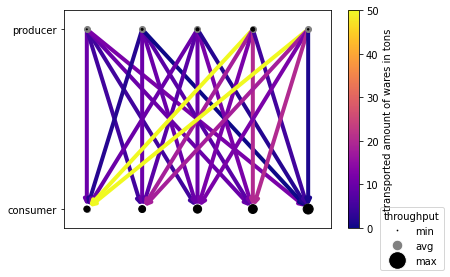

In [8]:
d = Drawer(myNW)
d.draw_it(product=['milk'], actor_type_names=['producer', 'consumer'])